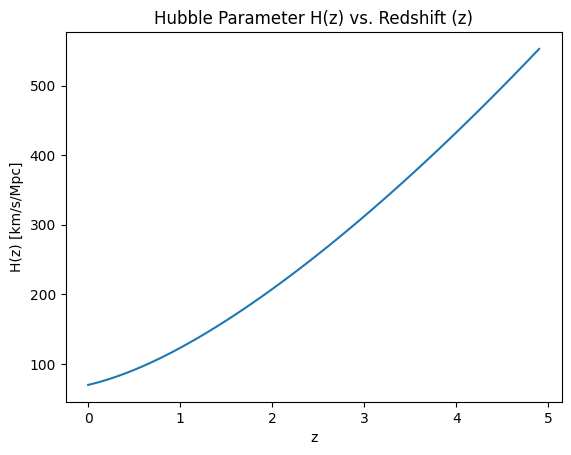

In [2]:
# Importing libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Defining cosmological constraints
H0 = 70 #km/sec/Mpc 
Om = 0.3 #present-day matter density parameter
Ol = 0.7 #present-day dark energy density parameter 
Ok = 0 #assuming a flat curvature of space 


# Defining the Hubble Parameter function assuming flat Lambda-CDM model
def Hubble(z, Om, Ol, Ok, H0):
    return H0 * np.sqrt(Om * (1 + z)**3 + Ok * (1 + z)**2 + Ol)

# Generating an array of redshift values from 0 to 5
z_values = np.arange(0,5,0.1) 

# Calculate the Hubble parameter H(z) for the given array of redshift values
H = Hubble(z_values, Om, Ol, Ok, H0) 

# Establishing the labels for the plot
plt.plot(z_values,H)
plt.xlabel('z')
plt.ylabel('H(z) [km/s/Mpc]')
plt.title('Hubble Parameter H(z) vs. Redshift (z)')

# Saving and displaying the plot
plt.savefig('Hubble Plot Assignment 1.png', dpi=200, bbox_inches="tight")
plt.show()


In [ ]:
# Importing libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

# Defining cosmological constraints
H0 = 70 # current expansion rate of the universe; km/s/Mpc 
Om = 0.3 #present-day matter density parameter
Ol = 0.7 #present-day dark energy density parameter 
Ok = 0 #assuming a flat curvature of space 
c = 299792.458 #speed of light; km/s 

# Defining the integrand function  
def integrand(z): 
    return 1 / (H0 * np.sqrt(Om * (1 + z)**3 + Ok * (1 + z)**2 + Ol))

# Vectorizing the integrand function
integrand_vec = np.vectorize(integrand)

# Defining the luminsoity distance function 
def d_L(z): 
    d_c, _ = integrate.quad(integrand_vec, 0, z) 
    return (1 + z) * d_c * c

# Generating an array of redshift values from 0 to 5
z_values = np.arange(0,5,0.1)

# Calculating the luminosity distance for the given array of redshift values
dL_values = [d_L(z) for z in z_values]

# Establishing the labels and title for the plot 
plt.plot(z_values,dL_values)
plt.xlabel('z')
plt.ylabel('D_L [Mpc]')
plt.title('Luminoisty Distance (D_L) vs. Redshift (z)')

# Saving and displaying the plot
plt.savefig('Luminosity Distance Plot Assignment 1.png', dpi=200, bbox_inches='tight')
plt.show()



C:\Users\misha\AppData\Local\Temp\ipykernel_7296\1044702129.py:36: RuntimeWarning: invalid value encountered in sqrt
  return H0 * np.sqrt(Om * (1 + z)**3 + Ol)


Maximum likelihood estimates:
Ω_m = 0.320
H0 = 68.148


100%|██████████| 50000/50000 [00:28<00:00, 1755.63it/s]


(1598720, 2)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

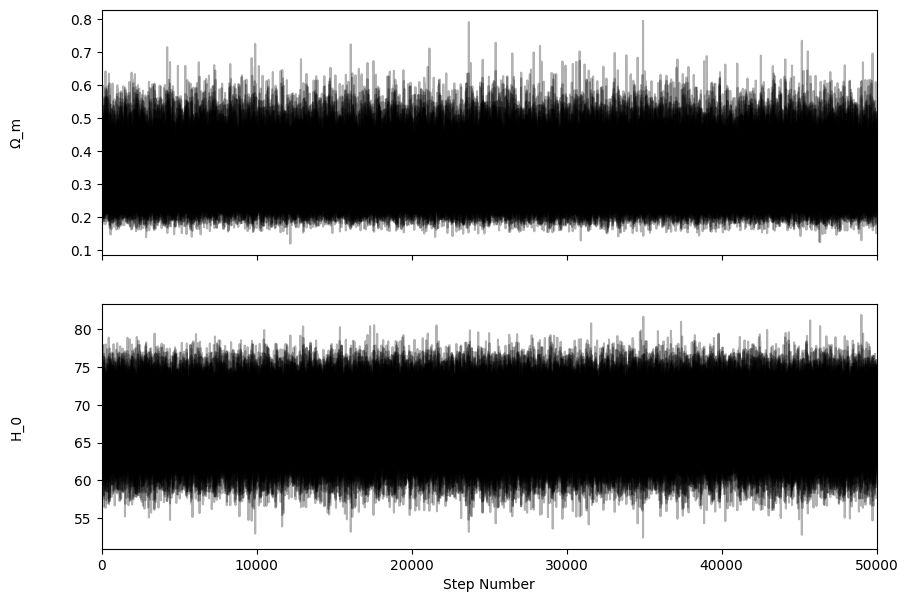

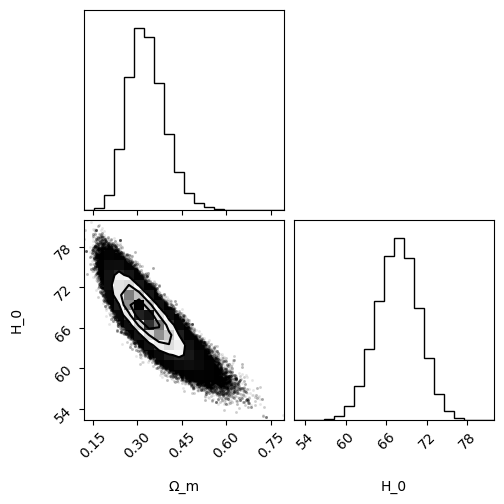

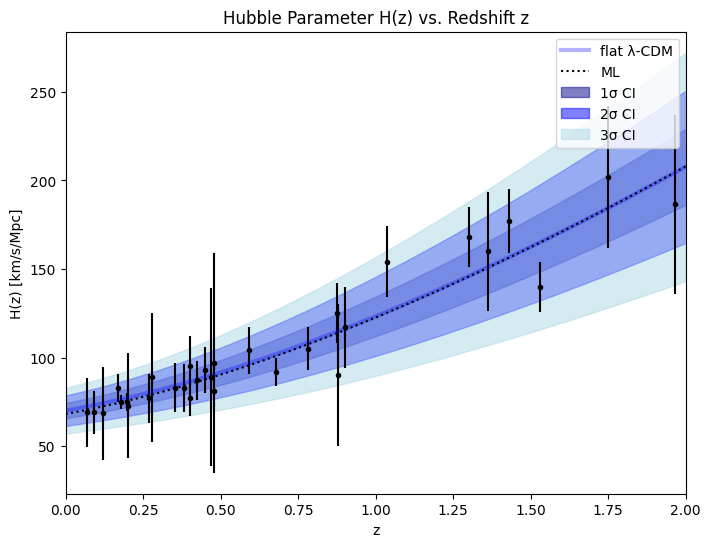

In [52]:
#Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimize
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import sympy as sp
import emcee
import tqdm 
import corner
from IPython.display import display, Math


# Reading the .dat file using pandas
data = pd.read_csv(r"C:\Users\misha\OneDrive\Desktop\Summer 2023 Reserach Internship\Hz_2016.dat", delimiter='\t')

# Extracting the data points 
z_Hz_error = data['z H(z) σ_H(z)']

# Split the combined column into separate columns for z, Hz, and error
z, Hz_data, Hz_error = zip(*[item.split() for item in z_Hz_error])

# Convert the data points to float 
z_data = np.array(list(map(float, z)))
Hz_data = np.array(list(map(float, Hz_data)))
Hz_error = np.array(list(map(float, Hz_error)))

# Defining cosmological constraints
H0 = 70 # current expansion rate of the universe; km/s/Mpc 
Om = 0.3 #present-day matter density parameter

# Defining the Hubble Parameter function assuming flat Lambda-CDM model
def Hubble(z, Om, H0):
    Ol = 1 - Om
    return H0 * np.sqrt(Om * (1 + z)**3 + Ol)

#------------------------------------------------------------------------------------------------------------

# ASSIGNMENT 2.1: 
    # Write a likelihood function 

# Define the log likelihood function
def log_likelihood(params, z, Hz_data, Hz_error):
    Omega_m, H0 = params
    Hz_predicted = Hubble(z, Omega_m, H0)
    sigma2 = Hz_error**2
    return -0.5 * np.sum((Hz_data - Hz_predicted)**2 / sigma2)

# Set the random seed
np.random.seed(42)

# Define the negative log-likelihood function
nll = lambda *args: -log_likelihood(*args)

# Define the initial parameter values
initial_params = np.array([0.3, 70], dtype=float) + 0.01 * np.random.randn(2)

# Perform maximum likelihood estimation using SLSQP
result = minimize(
    nll,
    initial_params,
    args=(z_data, Hz_data, Hz_error),
    method='SLSQP'
)

# Extract the parameter estimates
params_fit = result.x
Omega_m_fit, H0_fit = params_fit

# Print the maximum likelihood estimates
print("Maximum likelihood estimates:")
print("Ω_m = {0:.3f}".format(Omega_m_fit))
print("H0 = {0:.3f}".format(H0_fit))

#------------------------------------------------------------------------------------------------------------

# ASSIGNMENT 2.2: 
    # Use 2.1 in emcee

# Defining the log-prior function (up to a constant)
def log_prior(params):
    Omega_m, H0 = params
    if 0.0 < Omega_m < 1.0 and  50.0 < H0 < 100.0:
        return 0.0
    return -np.inf

# Define the full log-probability function
def log_probability(params, z, Hz_data, Hz_error):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(params, z, Hz_data, Hz_error)
    if np.isnan(ll):
        print("NaN encountered in log_likelihood. Parameters:", params)
        return -np.inf
    return lp + ll


# Initializing the sampler
pos =  params_fit + 1e-4 * np.random.randn(32, 2)  # Adjust the shape for the two cosmological parameters
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(z_data, Hz_data, Hz_error) 
)

# Run the MCMC sampling
sampler.run_mcmc(pos, 50000, progress=True);

# Create a figure with subplots
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

# Get the samples from the sampler
samples = sampler.get_chain()

# Define the labels for each parameter
labels = ["Ω_m", "H_0"]


# Iterate over each parameter
for i in range(ndim):
    ax = axes[i]  # tSelect the current subplot
    ax.plot(samples[:, :, i], "k", alpha=0.3)  # Plot the samples for the parameter
    ax.set_xlim(0, len(samples))  
    ax.set_ylabel(labels[i])  
    ax.yaxis.set_label_coords(-0.1, 0.5)  # Adjust the position of the y-axis label

# Set the x-axis label for he last subplot
axes[-1].set_xlabel("Step Number")

# Printing flat samples shape
flat_samples = sampler.get_chain(discard=40, thin=1, flat=True)
print(flat_samples.shape)

# Creating a corner plot 
fig = corner.corner(
    flat_samples,
    labels=labels,
    truths=[H0_fit, Omega_m_fit]
)

# Computing parameter uncertainties: 
for i in range(len(labels)):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = r"$\mathrm{{{0}}} = {1:.3f}_{{-{2:.3f}}}^{{{3:.3f}}}$".format(labels[i], mcmc[1], q[0], q[1])
    display(Math(txt))

#------------------------------------------------------------------------------------------------------------

# ASSIGNMENT 4.1c
    # Defining the error function for H(z) and plotting the confidence intervals (with shading for each region)

# Defining the exact derivative dH/dHo, dH/dOm, dH/dOl analytically
def dH_dH0(z, Om, H0):
    return np.sqrt(Om * (1 + z)**3 + Ol)
def dH_dOm(z, Om, H0):
    numerator = H0 * (1 + z)**3
    denominator = 2 * np.sqrt(Om * (1 + z)**3 +  Ol)
    return numerator / denominator
def dH_dOl(z, Om, H0):
    numerator_1 = H0 
    denominator_1 = 2 * np.sqrt(Om * (1 + z)**3 +  Ol)
    return numerator_1 / denominator_1

# Defining the error function for H(z) 
err_H0 = np.mean([3.031, 3.121]) 
err_Om = np.mean([0.056, 0.066])
err_Ol = err_Om 

def error_Hz(z, Om, H0, dH_dH0, dH_dOm, dH_dOl, err_H0, err_Om, err_Ol):
    return np.sqrt((dH_dH0(z, Om, H0) * err_H0)**2 + (dH_dOm(z, Om, H0) * err_Om)**2 + (dH_dOl(z, Om, H0) * err_Ol)**2)


# Define symbolic variables
z_sym = sp.symbols('z')
Om_sym = sp.symbols('Om')
H0_sym = sp.symbols('H0')

# Define the derivative functions
dH_dH0_sym = sp.sqrt(Om_sym * (1 + z_sym)**3 + (1 - Om_sym))
dH_dOm_sym = H0_sym * (1 + z_sym)**3 / (2 * sp.sqrt(Om_sym * (1 + z_sym)**3 + (1 - Om_sym)))
dH_dOl_sym = H0_sym / (2 * sp.sqrt(Om_sym * (1 + z_sym)**3 + (1 - Om_sym)))

# Convert symbolic functions to numerical functions
dH_dH0_fn = sp.lambdify((z_sym, Om_sym, H0_sym), dH_dH0_sym)
dH_dOm_fn = sp.lambdify((z_sym, Om_sym, H0_sym), dH_dOm_sym)
dH_dOl_fn = sp.lambdify((z_sym, Om_sym, H0_sym), dH_dOl_sym)


#------------------------------------------------------------------------------------------------------------

# Generating an array of redshift values from 0 to 5
z_values = np.arange(0, 2.05, 0.1)

# Calculate the true H(z) values
Hz_true = Hubble(z_values, Om, H0)

# Plotting the points on the graph 
plt.figure(figsize=(8, 6))
plt.errorbar(z_data, Hz_data, yerr=Hz_error, fmt=".k", capsize=0)

# Set error values for the first confidence interval
err_H0_values = np.full_like(z_values, err_H0)
err_Om_values = np.full_like(z_values, err_Om)
err_Ol_values = np.full_like(z_values, err_Ol)

# Calculate the Hubble values and errors for the first confidence interval 
error_values_1 = error_Hz(z_values, Om, H0, dH_dH0_fn, dH_dOm_fn, dH_dOl_fn, err_H0_values, err_Om_values, err_Ol_values)
H_values = Hubble(z_values, Om, H0)
H_lower_1 = H_values - error_values_1
H_upper_1 = H_values + error_values_1

# Set error values for the second confidence interval (twice the size of the first)
err_H0_values_2 = 2 * err_H0_values
err_Om_values_2 = 2 * err_Om_values
err_Ol_values_2 = 2 * err_Ol_values

# Calculate the Hubble values and errors for the second confidence interval
error_values_2 = error_Hz(z_values, Om, H0, dH_dH0_fn, dH_dOm_fn, dH_dOl_fn, err_H0_values_2, err_Om_values_2, err_Ol_values_2)
H_lower_2 = H_values - error_values_2
H_upper_2 = H_values + error_values_2

# Set error values for the third confidence interval (three times the size of the first)
err_H0_values_3 = 3 * err_H0_values
err_Om_values_3 = 3 * err_Om_values
err_Ol_values_3 = 3 * err_Ol_values

# Calculate the Hubble values and errors for the third confidence interval
error_values_3 = error_Hz(z_values, Om, H0, dH_dH0_fn, dH_dOm_fn, dH_dOl_fn, err_H0_values_3, err_Om_values_3, err_Ol_values_3)
H_lower_3 = H_values - error_values_3
H_upper_3 = H_values + error_values_3

# Graphing the true functiuon of H(z) 
plt.plot(z_values, Hz_true, color='blue', label='flat λ-CDM', alpha=0.3, lw=3)

# Graphing the maxmimum likelihood function of H(z)
z_range = np.linspace(0, 2.05, 100)
H_pred = Hubble(z_range, Omega_m_fit, H0_fit)
plt.plot(z_range, H_pred, ":k", label="ML")

# Graphing the projection of the results into the space of the observed data 
inds = np.random.randint(len(flat_samples), size=40)

# Grpahing the highlighted confidence intervals 
plt.fill_between(z_values, H_lower_1, H_upper_1, color='darkblue', alpha=0.5, label='1σ CI')
plt.fill_between(z_values, H_lower_2, H_upper_2, color='blue', alpha=0.5, label='2σ CI')
plt.fill_between(z_values, H_lower_3, H_upper_3, color='lightblue', alpha=0.5, label='3σ CI')


# Plotting the labels and figures on the plot
plt.xlabel('z')
plt.ylabel('H(z) [km/s/Mpc]')
plt.xlim(0, 2)
plt.title('Hubble Parameter H(z) vs. Redshift z')
plt.legend()

#Saving and displaying the plot
plt.savefig('Hubble Plot + Maximum Likelihood Estimation Assignment 2 + Confidence Intervals.png', dpi=200, bbox_inches="tight")
plt.show()

In [1]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as optimize
from scipy.optimize import minimize
from scipy.stats import pearsonr, spearmanr
import emcee
import tqdm 
import corner
from IPython.display import display, Math

# Reading the .txt files using pandas
CIV = r"C:\Users\misha\OneDrive\Desktop\Summer 2023 Reserach Internship\CIV_data.txt"
MgII = r"C:\Users\misha\OneDrive\Desktop\Summer 2023 Reserach Internship\MgII_data.txt"

# Read the .txt file
with open(CIV, 'r', encoding='utf-8') as file:
    lines = file.readlines()
with open(MgII, 'r', encoding='utf-8') as file:
    lines_1 = file.readlines()
lines = lines[1:] # Omitting the title names in .txt file 

# Extracting the data points
CIV_data = []
for line in lines[1:]:  # Exclude the first line
    values = line.strip().split(' ')
    if len(values) == 7:
        CIV_data.append(values[1:])  # Ignore the first column
    else:
        print(f"Ignoring line with incorrect number of values: {line.strip()}")

# Check if any valid data exists
if len(CIV_data) == 0:
    print("No valid data found in the file.")
    exit()


# Extracting the data points 
CIV_data = [line.strip().split(' ') for line in lines]
MgII_data = [line.strip().split(' ') for line in lines_1]

# Split the combined column into separate columns for z, Hz, and error
Object, z, log_F_1350, σ_F, log_L_1350, σ_L, 𝜏, σ_Lower, σ_Upper= zip(*CIV_data)
Object_3000, z_3000, log_F_3000, σ_F3000 𝜏_3000, σ_Lower3000, σ_Upper3000= zip(*MgII_data)

# Define a custom conversion function
def convert_float(value):
    if value == 'None':
        return np.nan
    else:
        return float(value.replace('−', '-'))

# Convert the data points to the appropriate data types (CIV) 
Object = np.array(Object)
z = np.array(z, dtype=float)
log_F_1350 = np.array(log_F_1350)
σ_F = np.array(σ_F)
log_L_1350 = np.array(log_L_1350)
σ_L = np.array(σ_L)
𝜏 = np.array(𝜏)
σ_Lower = np.array(σ_Lower)
σ_Upper = np.array(σ_Upper)

# Convert the data points to float (MgII) 
Object_3000 = np.array(Object_3000)
z_3000 = np.array(z_3000, dtype=float)
log_F_3000 = np.array(log_F_3000)
σ_F3000 = np.array(σ_F3000)
𝜏_3000 = np.array(𝜏_3000)
σ_Lower3000 = np.array(σ_Lower3000)
σ_Upper3000 = np.array(σ_Upper3000)



# Convert log_F_1350, 3000 and log_L_1350, 3000 to float
log_F_1350 = np.vectorize(convert_float)(log_F_1350)
log_L_1350 = np.vectorize(convert_float)(log_L_1350)

# Converting log_F_1350,3000 and log_L_1350,3000 into F_1350,3000 and L_1350,3000
F_1350 = np.power(10, np.array(log_F_1350, dtype=float))
L_1350 = np.power(10, np.array(log_L_1350, dtype=float))
log_𝜏 = np.log10(np.array(𝜏, dtype=np.float64))
log_σ_Lower = np.log10(np.abs(np.array(σ_Lower, dtype=np.float64)))
log_σ_Upper = np.log10(np.abs(np.array(σ_Upper, dtype=np.float64)))

# Calculate the Pearson correlation coefficient and p-value
pearson_corr, pearson_p_value = pearsonr(log_𝜏, log_L_1350)

# Calculate the Spearman correlation coefficient and p-value
spearman_corr, spearman_p_value = spearmanr(log_𝜏, log_L_1350)

# Output the correlation coefficients and p-values
print("Pearson correlation coefficient between log(𝜏) and log(L_1350):", pearson_corr)
print("Pearson correlation p-value between log(𝜏) and log(L_1350):", pearson_p_value)
print("Spearman correlation coefficient between log(𝜏) and log(L_1350):", spearman_corr)
print("Spearman correlation p-value between log(𝜏) and log(L_1350):", spearman_p_value)

# Take absolute value of negative errors
log_σ_Lower[log_σ_Lower < 0] *= -1
log_σ_Upper[log_σ_Upper < 0] *= -1

# Plotting the labels and figures on the plot
plt.errorbar(log_L_1350, log_𝜏, yerr=[log_σ_Lower, np.zeros_like(log_𝜏)], fmt='ro', ecolor='r', label='Lower Error')
plt.errorbar(log_L_1350, log_𝜏, yerr=[np.zeros_like(log_𝜏), log_σ_Upper], fmt='ro', ecolor='b', label='Upper Error')
plt.xlabel('log(L_1350 [erg s^-1])')
plt.ylabel('log(tau [day])')
plt.title('R-L correlation for Mg II and C IV QSOs')
plt.legend()

#Saving and displaying the plot
plt.savefig('R-L Plot Assignment #4', dpi=200, bbox_inches="tight")
plt.show()

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1585153188.py, line 45)